In [1]:
# Setup (PyTorch, paths, device, seeds)
%load_ext autoreload
%autoreload 2

from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold
)

from xray_helpers import (
    seed_all, compute_pos_weight,show_split_counts,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cpu


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-3

In [4]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

Train dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
Train dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Val dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Val dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Test dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
Test dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


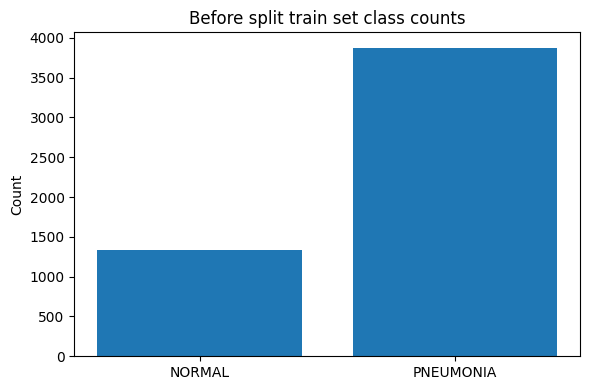

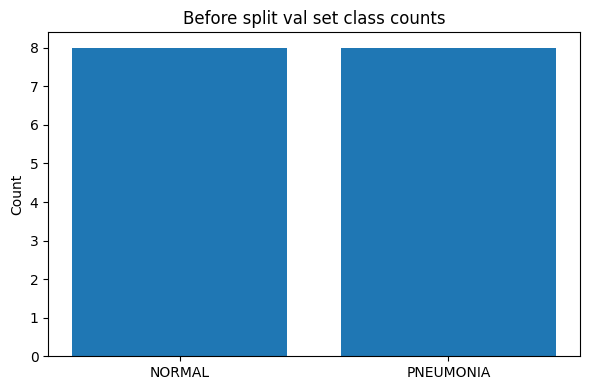

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


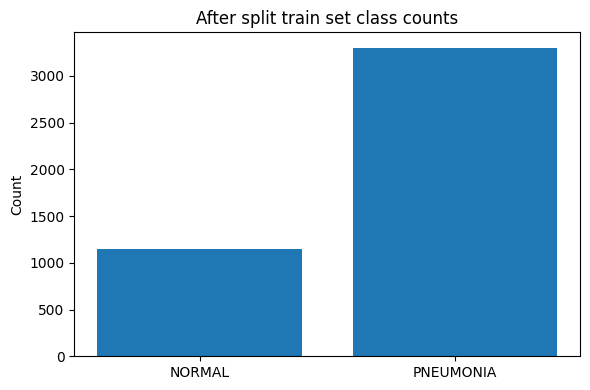

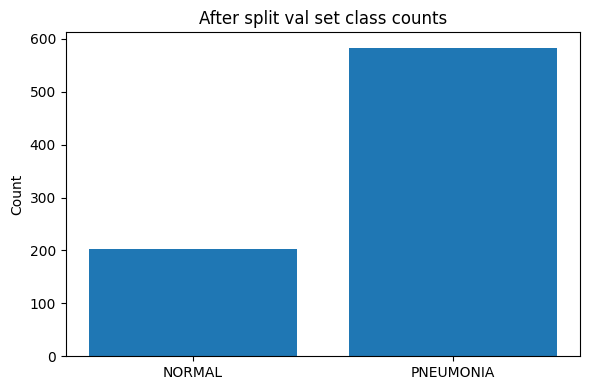

In [5]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

In [6]:
model = PneumoCNN()
model = model.to(device)

data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, IMG_SIZE, BATCH_SIZE, NUM_WORKERS)

print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history, best_val_auc = fit(model, loaders['train_loader'], loaders['val_loader'],
                            criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)

plot_curves(history)

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


[Train] Epoch 1/15:   0%|          | 0/20 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-pa

In [ ]:
_, _, va_auc, va_probs, va_targets = eval_one_epoch(model, loaders['val_loader'], epochNumber=0, criterion=criterion)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

In [ ]:
evaluate_with_threshold(model, loaders['test_loader'], criterion, threshold=best_thr)